In [15]:
import pandas as pd
import numpy as np
import datetime
import time

import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt

from tda import auth, client
import json
from config import api_key, redirect_uri, token_path, account_id, executable_path

# Machine learning libraries
from sklearn.svm import SVC
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix, recall_score, precision_score, classification_report
import talib as ta
import pytz

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 300)
import warnings
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
def data_cleaning_engineering(df):
    """ Prepare data for modeling. Engineering Financial Indicators """
    # Drop the rows with zero volume traded
    df = df.drop(df[df['volume'] == 0].index)
    # Create a variable n with a value of 10
    n = 10
    # Create a column by name, RSI and assign the calculation of RSI to it
    df['RSI'] = ta.RSI(np.array(df['close'].shift(1)), timeperiod=n)
    
    # Create a column by name, SMA and assign the SMA calculation to it
    df['SMA'] = df['close'].shift(1).rolling(window=n).mean()
    # Create a column by name, Corr and assign the calculation of correlation to it
    df['Corr'] = df['close'].shift(1).rolling(window=n).corr(df['SMA'].shift(1))
    # Create a column by name, SAR and assign the SAR calculation to it
    df['SAR'] = ta.SAR(np.array(df['high'].shift(1)), np.array(df['low'].shift(1)), 0.2, 0.2)
    # Create a column by name, ADX and assign the ADX calculation to it
    df['ADX'] = ta.ADX(np.array(df['high'].shift(1)), np.array(df['low'].shift(1)),
                       np.array(df['open']), timeperiod=n)
    
    # Create columns high, low and close with previous minute's OHLC data
    df['Prev_High'] = df['high'].shift(1)
    df['Prev_Low'] = df['low'].shift(1)
    df['Prev_Close'] = df['close'].shift(1)

    # Create columns 'OO' with the difference between the current minute's open and last minute's open
    df['OO'] = df['open']-df['open'].shift(1)
    # Create columns 'OC' with the difference between the current minute's open and last minute's close
    df['OC'] = df['open']-df['Prev_Close']
    
    # (close-low)/(high-low)
    df['Normalized'] = (df['close']-df['low'])/(df['high']-df['low'])
    
    # calculate slope of regression for Close price of last 3,5,10,20 min
    for day,reg_period in zip([3,5,10,20], ['reg_3','reg_5', 'reg_10', 'reg_20']):
        df[reg_period] =  df['close'].rolling(window=day).apply(get_slope, raw=False)
        
    # Create a column 'Ret' with the calculation of returns
    df['Ret'] = (df['open'].shift(-1)-df['open'])/df['open']

    # Create n columns and assign
    for i in range(1, n):
        df['return%i' % i] = df['Ret'].shift(i)
    df.iloc[-1:] = df.iloc[-1:].fillna(0)
    
    # Additional Cleaning 
    # Change the value of 'Corr' to -1 if it is less than -1
    df.loc[df['Corr'] < -1, 'Corr'] = -1
    # Change the value of 'Corr' to 1 if it is greater than 1
    df.loc[df['Corr'] > 1, 'Corr'] = 1
    # Drop the NaN values
    df = df.dropna()
    
    # Create a column by name, 'Signal' and initialize with 0
    df['Signal'] = 0
    # Assign a value of 1 to 'Signal' column for the quantile with the highest returns
    df.loc[df['Ret'] > df['Ret'].quantile(q=0.66), 'Signal'] = 1
    # Assign a value of -1 to 'Signal' column for the quantile with the lowest returns
    df.loc[df['Ret'] < df['Ret'].quantile(q=0.34), 'Signal'] = -1
    
    return df

In [21]:
def train_classifier_predict(df):
    """ Training Model with Best Params and make prediction for the last min data """
    # Use drop method to drop the columns
    X = df.drop(['close', 'Signal', 'high', 'volume', 'low', 'Ret'], axis=1)
    # Create a variable which contains all the 'Signal' values
    y = df['Signal']
    
    # Create a variable split that stores 80% of the length of the dataframe
    t = .98
    split = int(t*len(df))
    
    # Test variables for 'c' and 'g'
    #Setting the different values to test within C, Gamma and Kernel
    c = [10, 100, 1000, 10000]
    g = [1e-2, 1e-1, 1e0]
    # Intialise the parameters
    parameters = {'svc__C': c,
                  'svc__gamma': g,
                  'svc__kernel': ['rbf']}
    #Creating the step by step pipeline
    # Create the 'steps' variable with the pipeline functions
    steps = [('scaler', StandardScaler()), ('svc', SVC())]
    # Pass the 'steps' to the Pipeline function
    pipeline = Pipeline(steps)
    #Creating a randomized function to help to find the best parameters.
    # Call the RandomizedSearchCV function and pass the parameters
    rcv = RandomizedSearchCV(pipeline, parameters, cv=TimeSeriesSplit(n_splits=10))
    
    # Call the 'fit' method of rcv and pass the train data to it
    rcv.fit(X.iloc[:split], y.iloc[:split])
    # Call the 'best_params_' method to obtain the best parameters of C
    best_C = rcv.best_params_['svc__C']
    # Call the 'best_params_' method to obtain the best parameters of kernel
    best_kernel = rcv.best_params_['svc__kernel']
    # Call the 'best_params_' method to obtain the best parameters of gamma
    best_gamma = rcv.best_params_['svc__gamma']
    
    # Create a new SVC classifier
    cls = SVC(C=best_C, kernel = best_kernel, gamma=best_gamma)
    # Instantiate the StandardScaler
    ss1 = StandardScaler()
    # Pass the scaled train data to the SVC classifier
    cls.fit(ss1.fit_transform(X.iloc[:split]), y.iloc[:split])
    
    y_predict = cls.predict(ss1.transform(X.iloc[split:]))
    cm = confusion_matrix(y.iloc[split:], y_predict)
    accuracy  = np.trace(cm) / float(np.sum(cm))
    
    prediction = cls.predict(ss1.transform(X.iloc[-1:]))
    timestamp = X.iloc[-1:].index
    return timestamp, int(prediction), X.iloc[-1:], accuracy

In [22]:
def get_slope(array):
    """ calculate a slope of line cross points in array with OLSR """
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope

def get_account_acess(api_key, redirect_uri, token_path, account_id, executable_path):
    """ Creates a client with credantials which allows to make API calls """
    try:
        c = auth.client_from_token_file(token_path, api_key)
    except FileNotFoundError:
        from selenium import webdriver
        with webdriver.Chrome(executable_path = executable_path) as driver:
            c = auth.client_from_login_flow(
                driver, api_key, redirect_uri, token_path)
    return c

def keep_trade_history(current_time, quote, pred_signal, accuracy):
    
    # if no orders executed yet and pred signal 1 - add new signal order
    if len(d_current_trading_signal['Pred_sig']) == 0 and pred_signal==1:
        d_current_trading_signal['Pred_sig'][current_time] = pred_signal
        d_current_trading_signal['accuracy'][current_time] = accuracy
        d_current_trading_signal['quote'][current_time] = quote
    # if pred signal 1 but last filled order was 1 - pass
    elif pred_signal == 1 and list(d_current_trading_signal['Pred_sig'].items())[-1][1] == 1:
        pass
    # if pred signal -1 and there is no previous signal - pass
    elif pred_signal == -1 and len(d_current_trading_signal['Pred_sig']) == 0:
        pass
    # if pred signal -1 but last filled order was -1 - pass
    elif pred_signal == -1 and list(d_current_trading_signal['Pred_sig'].items())[-1][1] == -1:
        pass
    # if pred signal 1 but last filled order was -1 - add new signal order
    elif pred_signal == 1 and list(d_current_trading_signal['Pred_sig'].items())[-1][1] == -1:
        d_current_trading_signal['Pred_sig'][current_time] = pred_signal
        d_current_trading_signal['accuracy'][current_time] = accuracy
        d_current_trading_signal['quote'][current_time] = quote
    # if pred signal -1 but last filled order was 1 - add new signal order
    elif pred_signal == -1 and list(d_current_trading_signal['Pred_sig'].items())[-1][1] == 1:
        d_current_trading_signal['Pred_sig'][current_time] = pred_signal
        d_current_trading_signal['accuracy'][current_time] = accuracy
        d_current_trading_signal['quote'][current_time] = quote
    else: pass
    
def timer(new_minute = False, timezone = pytz.timezone('America/New_York')):
    """ Getting current time every 5s and checking if current time exist
        in time_list(by minutes). Once current time match any in time_list
        remove value from time_list and return True value
    """
    while new_minute==False:
        # get current minute
        current_time = datetime.datetime.strftime(datetime.datetime.now(tz = timezone), '%Y-%m-%d %H:%M')
        if  current_time in time_list: # if current time appears in time_list
            time_list.remove(current_time) # remove current time from time_list
            break # exit loop and return True
        time.sleep(5)
    return True

def results_to_dict(current_time, latest_minute_respond, quote, buy_power, pred_signal, accuracy):
    """ Saving results from API calls and modeling to dict """
    d_result_position_signal['respond_timestamp'][current_time] = latest_minute_respond
    d_result_position_signal['Pred_Signal'][current_time] = pred_signal
    d_result_position_signal['accuracy'][current_time] = accuracy
    d_result_position_signal['quote'][current_time] = quote
    d_result_position_signal['buy_power'][current_time] = buy_power
    return

def get_hist_data(connection, symbol, start_datetime):
    """API calls to get historical stock data by minute"""
    df = pd.DataFrame(connection.get_price_history_every_minute(symbol, 
                                                                start_datetime = datetime.datetime.fromisoformat('2022-04-14 09:30:00'),
                                                                need_extended_hours_data=False).json()['candles'])
    df['datetime'] = df['datetime'].apply(lambda x : datetime.datetime.fromtimestamp(x/1000.0))
    df['datetime'] = df['datetime'].apply(lambda x: datetime.datetime.strftime(x, '%Y-%m-%d %H:%M:%S'))
    df = df.set_index('datetime')
    return df

def current_min_data(connection, symbol, current_time, start_datetime, latest_data_avail = False):
    """ API request for historycal data and checking if there is data about current minute """
    while latest_data_avail == False:
        # get historical data about EQUITY for modeling
        stock_hist_data = get_hist_data(connection, symbol, start_datetime)
        latest_minute_respond = stock_hist_data.iloc[-1:].index[0][:-3]
        if current_time == latest_minute_respond:
            break
        else:
            time.sleep(1)
    return latest_minute_respond, stock_hist_data 

def generate_datetimes(date_from_str, minutes_count):
    date_from = datetime.datetime.strptime(date_from_str, '%Y-%m-%d %H:%M:%S')
    for minute in range(minutes_count): #390 #interval minutes from starting time
        yield date_from + datetime.timedelta(minutes=minute)
        
def initialize_results_frame(date_from_str, minutes_count):
    """ Initialise frame for results 
        Args: 
            date_from_str(str)-starting day,time,min for timelist/'2022-04-13 09:30:00'/
            minutes_count(int)-number of minutes from date_from_str
        Rrt:
            time_list - with 1 min interval
            d_result_position_signal - dict with records from API calls
    """
    time_list=[date.strftime('%Y-%m-%d %H:%M') for date in generate_datetimes(date_from_str, minutes_count)]
    # dict with results from API calls and modeling
    d = {}; d['respond_timestamp']={}; d['quote']={}; d['Pred_Signal']={}; d['buy_power']={}; d['accuracy']={}
    # dict for tracking latest pred_signals
    d_hist_s = {}; d_hist_s['Pred_sig']={}; d_hist_s['accuracy']={}; d_hist_s['quote']={}
    return time_list, d, d_hist_s

In [23]:
def run(symbol='TSLA', start_datetime='2022-04-14 09:30:00'):
    """ * creates connection for API calls
        * gets historical data of symbol and quote
        * runs ML model 
        * gets account info
        * save results """
    if timer() == True:
        accuracy, latest_minute_respond = False, False
        # get current minute
        current_time = datetime.datetime.strftime(datetime.datetime.now(tz=pytz.timezone('America/New_York')), '%Y-%m-%d %H:%M')
        # authorize connection. create a client for API calls
        connection = get_account_acess(api_key, redirect_uri, token_path, account_id, executable_path)
        try:
            # get historical data about EQUITY for modeling up to current_minute
            latest_minute_respond, stock_hist_data = current_min_data(latest_data_avail=False, 
                                                                      start_datetime=start_datetime,
                                                                      current_time=current_time,
                                                                      connection=connection, 
                                                                      symbol=symbol)        
            # cleaning data and prepare for modeling                                                                 
            data_clean = data_cleaning_engineering(stock_hist_data)
            # run the model and make a prediction on a last input
            respond_timestamp, pred_signal, last_min_data, accuracy = train_classifier_predict(data_clean)
            # get current quote of the equity
            quote = connection.get_quote(symbol).json()[symbol]['askPrice']
            # get account information (avail funds for trade)
            buy_power = connection.get_account(account_id=account_id).json()['securitiesAccount']['currentBalances']['buyingPowerNonMarginableTrade']
            #saving results to the dict.
            results_to_dict(current_time, latest_minute_respond, quote, buy_power, pred_signal, round(accuracy,2))
            # filling with records about trades:
            keep_trade_history(current_time, quote, pred_signal, round(accuracy,2))
            hist_last_min_data.append(last_min_data)
        except:
            print(f"There is no API respond for {current_time}")
            
        if len(time_list)==0: return print('Time is over')
        elif accuracy and latest_minute_respond:
            print(f"Results for {latest_minute_respond} saved with classifier accuracy: {accuracy}") 
        else:
            print(f"There is no results for {current_time} and classifier accuracy: {None}") 
        run()
    return 

In [26]:
###### DECLARE GLOBAL VARIABLES #######0
time_list, d_result_position_signal, d_current_trading_signal = initialize_results_frame(date_from_str='2022-04-22 11:05:00', minutes_count=295)
hist_last_min_data = []

print(d_current_trading_signal)
print(d_result_position_signal)
print(time_list[-5:])

{'Pred_sig': {}, 'accuracy': {}, 'quote': {}}
{'respond_timestamp': {}, 'quote': {}, 'Pred_Signal': {}, 'buy_power': {}, 'accuracy': {}}
['2022-04-22 15:55', '2022-04-22 15:56', '2022-04-22 15:57', '2022-04-22 15:58', '2022-04-22 15:59']


In [27]:
run()

Results for 2022-04-22 11:05 saved with classifier accuracy: 0.7317073170731707
Results for 2022-04-22 11:06 saved with classifier accuracy: 0.7317073170731707
Results for 2022-04-22 11:07 saved with classifier accuracy: 0.7317073170731707
Results for 2022-04-22 11:08 saved with classifier accuracy: 0.7317073170731707
Results for 2022-04-22 11:09 saved with classifier accuracy: 0.7560975609756098
Results for 2022-04-22 11:10 saved with classifier accuracy: 0.8536585365853658
Results for 2022-04-22 11:11 saved with classifier accuracy: 0.7560975609756098
Results for 2022-04-22 11:12 saved with classifier accuracy: 0.7804878048780488
Results for 2022-04-22 11:13 saved with classifier accuracy: 0.7317073170731707
Results for 2022-04-22 11:14 saved with classifier accuracy: 0.7317073170731707
Results for 2022-04-22 11:15 saved with classifier accuracy: 0.8048780487804879
Results for 2022-04-22 11:16 saved with classifier accuracy: 0.7317073170731707
Results for 2022-04-22 11:17 saved with 

ValueError: list.remove(x): x not in list

In [29]:
df_current_trading_signal = pd.DataFrame(d_current_trading_signal)
df_result_position_signal = pd.DataFrame(d_result_position_signal)
df_hist_last_min_data = pd.concat(hist_last_min_data)

In [27]:
# df_current_trading_signal.to_csv('df_current_trading_signal_4_20.csv')
# df_result_position_signal.to_csv('df_result_position_signal_4_20.csv')
# df_hist_last_min_data.to_csv('df_hist_last_min_data_4_20.csv')

In [32]:
# df_current_trading_signal = pd.read_csv('df_current_trading_signal_4_20.csv', index_col='Unnamed: 0')
# df_result_position_signal = pd.read_csv('df_result_position_signal_4_20.csv', index_col='Unnamed: 0')
# df_hist_last_min_data = pd.read_csv('df_hist_last_min_data_4_20.csv', index_col='datetime')

In [28]:
# df_result_position_signal.head(100)

### Analysis of results

In [30]:
# calculate pct return at each switch signal
df_result_position_signal['Return'] = 100*df_result_position_signal['quote'].pct_change()
df_result_position_signal['Return'] = np.where(df_result_position_signal['Pred_Signal']==-1, df_result_position_signal['Return'], np.nan)
df_result_position_signal= df_result_position_signal.reset_index()
df_result_position_signal =  df_result_position_signal.rename(columns={'index':'datetime'})
df_result_position_signal['cum_sum_return'] = df_result_position_signal['Return'].cumsum()

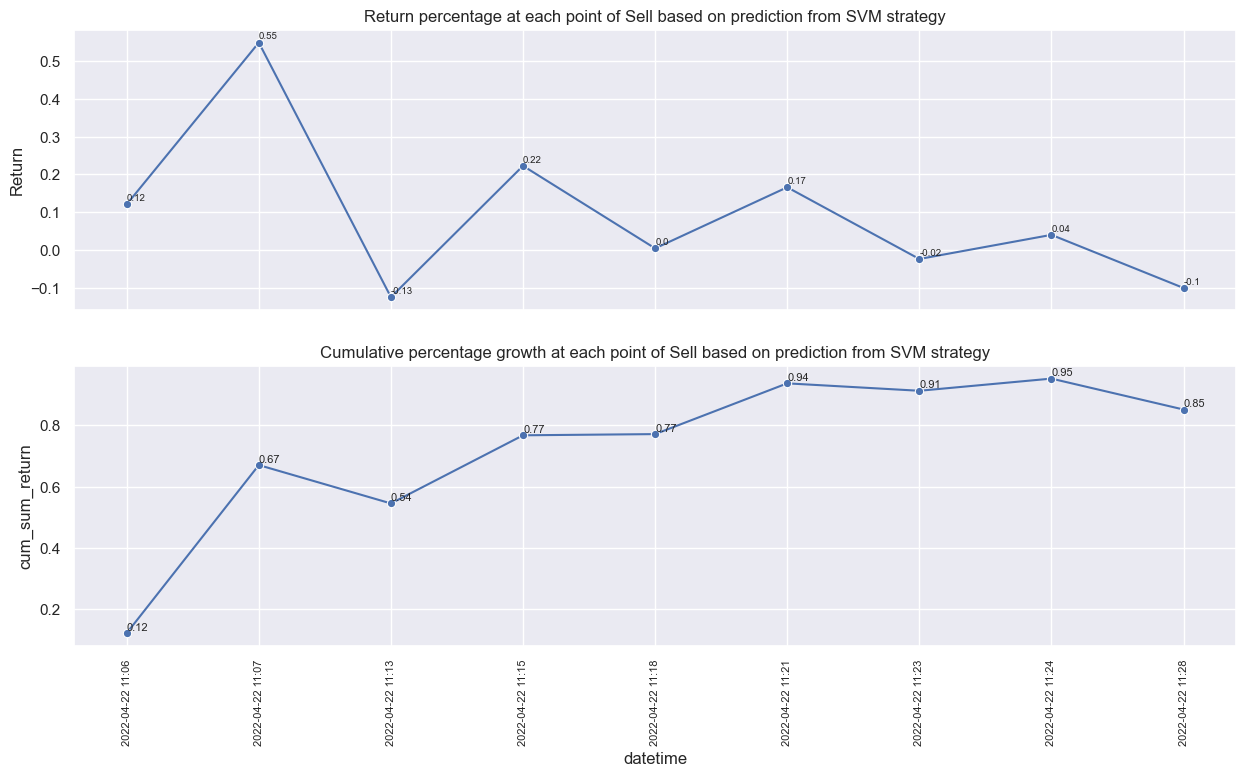

In [31]:
fig, ax = plt.subplots(2,1, figsize=(15,8))

ax[0].set_title('Return percentage at each point of Sell based on prediction from SVM strategy')
ax[0].set_ylabel('Return, pct')
plt.setp(ax[0].get_xticklabels(), visible=False)
sns.lineplot(x='datetime', y='Return', data=df_result_position_signal, marker='o', ax=ax[0])
for xx,yy,m in df_result_position_signal[['datetime','Return','Return']].dropna().values:
        ax[0].text(xx,yy+0.01,round(m,2), size =7, rotation =0)

ax[1].set_title('Cumulative percentage growth at each point of Sell based on prediction from SVM strategy')
plt.setp(ax[1].get_xticklabels(), rotation=90, size =8)
sns.lineplot(x='datetime', y='cum_sum_return', data=df_result_position_signal, marker='o', ax=ax[1])
for xx,yy,m in df_result_position_signal[['datetime','cum_sum_return','cum_sum_return']].dropna().values:
        ax[1].text(xx,yy+0.01,round(m,2), size =8, rotation =0)
# plt.tight_layout()
plt.show()

In [54]:
df_result_position_signal.to_csv('testing_bot_results_4_19.csv', index=False)